In [1]:
from collections import Counter
from dataset_formatted import df
from collections import defaultdict
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import pandas as pd
import tldextract
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer


# <span style="color:black">Basic Characteristics of Our Dataset:</span>



In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 599
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Question                         500 non-null    object 
 1   Question Category                500 non-null    object 
 2   LLM                              500 non-null    object 
 3   Attributed Sources               366 non-null    object 
 4   Number of Sources                485 non-null    float64
 5   Are All Source Links Functional  368 non-null    object 
 6   Multi-modal Response             484 non-null    object 
dtypes: float64(1), object(6)
memory usage: 31.2+ KB


#### Handling Missing/Null Values:

In [3]:
df.isnull().sum()

Question                             0
Question Category                    0
LLM                                  0
Attributed Sources                 134
Number of Sources                   15
Are All Source Links Functional    132
Multi-modal Response                16
dtype: int64

#### We chose to fill our null values instead of removing the rows containing them to retain as much data as we could in our dataset.  Removing rows with null values in our dataset could have resulted in an almost 60% reduction in our dataset.  We decided to fill these with '0' for numerical columns and empty strings ('') for categorical columns because we knew in our original dataset that the absence of values in these rows/columns meant that the model did not provide these, therefore 0/'' is most accurate.  Alternatives often used are filling in missing data with the median value, and more robust approaches consist of using imputation methods, such as K-Nearest Neighbor, Trees, and Linear Methods [1].

[1]: **[*Feature Engineering and Selection:  A Practical Approach for Predictive Models* | Authors:  Max Kuhn & Kjell Johnson | Section 8.5 - "Imputation Methods"](http://www.feat.engineering/)** 

In [4]:
df['Number of Sources'] = df['Number of Sources'].fillna(0)

# The below columns will eventually be one hot encoded, but for the time being we are filling the null values in the below columns with the most applicable empty data type.
df['Attributed Sources'] = df['Attributed Sources'].fillna('')

# The absence values in this column functionally are the same thing as having non-functional links for the purposes of this project, and therefore are being filled with 'no_links_functional'.
df['Are All Source Links Functional'] = df['Are All Source Links Functional'].fillna('no_links_functional')

# Same as link functionality, the absence of a value for response type is functionally the same thing as text_only.
df['Multi-modal Response'] = df['Multi-modal Response'].fillna('text_only')

df.isnull().sum()

Question                           0
Question Category                  0
LLM                                0
Attributed Sources                 0
Number of Sources                  0
Are All Source Links Functional    0
Multi-modal Response               0
dtype: int64

In [5]:
df.head(10)

,Question,Question Category,LLM,Attributed Sources,Number of Sources,Are All Source Links Functional,Multi-modal Response
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,all_links_functional,text_only
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,all_links_functional,text_only
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,all_links_functional,text_only
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,all_links_functional,text_only
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,all_links_functional,text_only
5,"""how many branches of reserve bank of india in...",Economics & Commerce,gemini,www.wikipedia.org,1.0,all_links_functional,text_only
6,"""when is the last time the new york giants won...",Sports,gemini,www.britannica.com,1.0,all_links_functional,text_only
7,"""where does eye of the round roast come from""",Food & Cooking,gemini,www.beefitswhatsfordinner.com. www.newzealmeat...,2.0,all_links_functional,text_only
8,"""who played mrs warboys in one foot in the grave""",Entertainment,gemini,www.wikipedia.org,1.0,all_links_functional,multi-modal
9,"""who wins the next iron chef super chefs""",Food & Cooking,gemini,www.wikipedia.org,1.0,all_links_functional,text_only


#### Checking the distribution & value counts for the preponderance of our feature columns

Before we start diving into data transformation and model development, we wanted to see our feature column distributions of values.  This is often considered best practice to help you identify outliers, percentiles, and counts.

In [6]:
df['Number of Sources'].describe()

count    500.000000
mean       3.984000
std        3.911822
min        0.000000
25%        0.000000
50%        3.000000
75%        7.000000
max       18.000000
Name: Number of Sources, dtype: float64

In [7]:
df['Are All Source Links Functional'].value_counts()

Are All Source Links Functional
all_links_functional     352
no_links_functional      135
some_links_functional     13
Name: count, dtype: int64

In [8]:
df['Multi-modal Response'].value_counts()

Multi-modal Response
text_only      385
multi-modal    115
Name: count, dtype: int64

In [9]:
# Because we ask the same 100 questions to each model, we only want to conduct a value count on the first 100 rows of the dataset.
question_category_breakdown = df.iloc[0:100].groupby('Question Category')['Question Category'].value_counts()
print(question_category_breakdown)

Question Category
Economics & Commerce     7
Entertainment           25
Food & Cooking           3
General Knowledge        3
Geography                5
History                 18
Literature               5
Philosophy               3
Politics                 5
Science & Technology    17
Sports                   9
Name: count, dtype: int64


## <span style="color:black">Analysis of `'Question Category'`</span>

Our 100 questions/prompts were randomly selected using Panda's `sample()` method:

`random_100 = df.sample(n=100)`


To understand the distribution of the questions randomly selected and their corresponding category (which we manually defined in our dataset), we conducted the following counts by category.  We discovered some question categories, such as *Entertainment, History, and Science & Technology*, are more dominant in the dataset than other categories.  This could potentially explain certain characteristics of our dataset, particularly the types and frequencies of sources provided in LLM model responses, which will be discussed in more detail in the final report.

We did not find any specific information in Google's Natural Question documentation, however, in the related paper *Natural Questions: a Benchmark for Question Answering Research*, the authors state, "Questions consist of real anonymized, aggregated queries issued to the Google search engine."[2]

We manually determined and assigned the categories to the questions.  To do this, we reviewed the questions and grouped them into one of the 11 categories.  We felt that we needed to ensure that the categories were specific enough to accurately describe the question, but we wanted to ensure we did not go too granular to lose obvious correlations between the questions (i.e. history, sports, etc.).

[1]: **[Google's Natural Questions](https://ai.google.com/research/NaturalQuestions)** 

[2]: **[Natural Questions: a Benchmark for Question Answering Research](https://storage.googleapis.com/gweb-research2023-media/pubtools/4852.pdf)** 

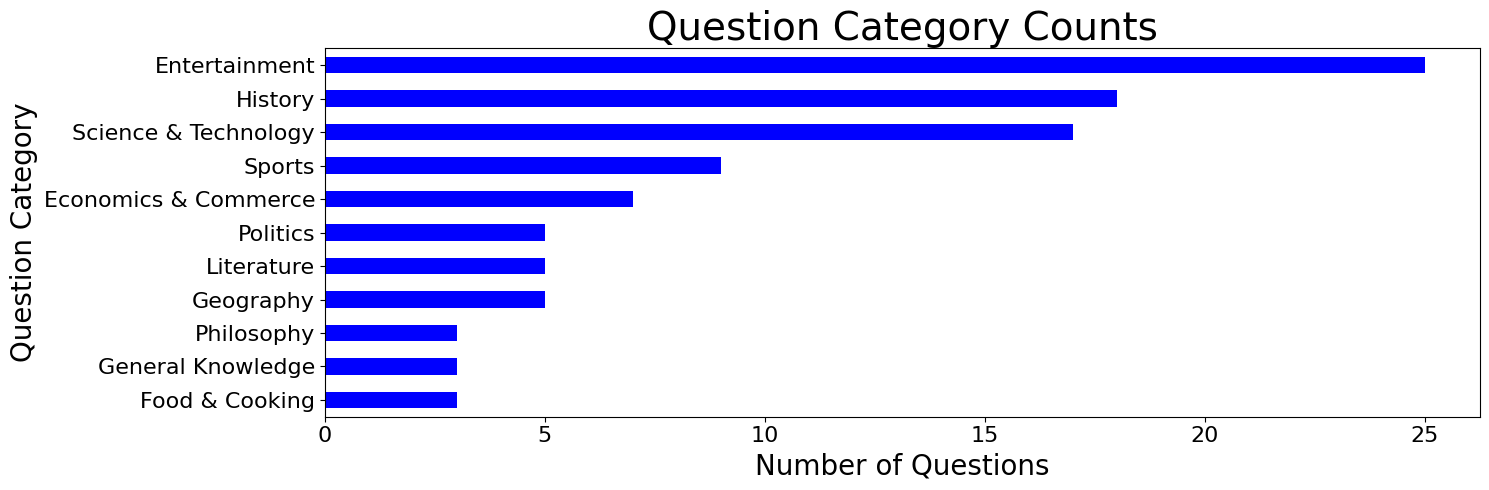


Question Category Counts 

Question Category
Economics & Commerce     7
Entertainment           25
Food & Cooking           3
General Knowledge        3
Geography                5
History                 18
Literature               5
Philosophy               3
Politics                 5
Science & Technology    17
Sports                   9
Name: Question Category, dtype: int64 




In [63]:
question_category_breakdown = df.iloc[0:100].groupby('Question Category')['Question Category'].count()
plt.figure(figsize=(15, 5))
question_category_breakdown.sort_values().plot(kind='barh', color='blue')
plt.title('Question Category Counts', fontsize=28)
plt.xlabel('Number of Questions', fontsize=20)
plt.ylabel('Question Category', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

print(f'\nQuestion Category Counts \n\n{question_category_breakdown}', '\n\n')

# trust_score_by_model_by_category = df_trust_score.pivot_table(index='Question Category', columns='LLM', values='Trust Score', aggfunc='mean')
# trust_score_by_model_by_category.plot(kind='bar', figsize=(20, 10))
# plt.title('Trust Score by Model and Question Category', fontsize=28)
# plt.xlabel('Question Category', fontsize=20)
# plt.ylabel('Mean Trust Score', fontsize=20)
# plt.xticks(rotation=45, fontsize=16)
# plt.yticks(fontsize=16)
# # plt.legend(title='Model', fontsize=16)
# plt.legend(title='Model', fontsize=16, title_fontsize=20, 
#           bbox_to_anchor=(1, 1), 
#           loc='upper left')
# plt.tight_layout()
# plt.show()


#### <span style="color:blue">*Plot Insights:*</span> As can be clearly seen, there is some significant imbalances between the counts of questions across categories captured in our dataset.  Future improvements to this project could include verifying our category creation and assignments are accurate/fully capture the essence of our data (questions).  Additionally, it is worth noting that we could also supplement our dataset with more data from the under-represented categories.

# <span style="color:black">Prompting & Response Performance Statistics</span>

### <span style="color:black">Evaluate Variations in Source Attribution</span>

In [11]:
# To avoid creating any issues with the original dataset, we created a deepy copy to run our analysis on the LLM's performance metrics.
df_perf_stats = df.__deepcopy__()

# Total number of sources by model
total_number_of_sources_by_model = df_perf_stats.groupby('LLM')['Number of Sources'].sum()
print(f'\nTotal Number of Sources by Model \n\n{total_number_of_sources_by_model}', '\n\n')

# MODEL METRICS TABLE - 'Number of Sources (AVG)':  Avg number of sources by model
avg_number_of_sources_by_model = df_perf_stats.groupby('LLM')['Number of Sources'].mean()
print(f'\nAverage Number of Sources by Model \n\n{avg_number_of_sources_by_model}', '\n\n')

# MODEL METRICS TABLE - 'Multi-Modal':  Percentage of multi-modal responses by model
df_perf_stats['Multi-modal Response'] = df_perf_stats['Multi-modal Response'].apply(lambda x: 1 if x == 'multi-modal' else 0)
percentage_multi_modal_by_model = df_perf_stats.groupby('LLM')['Multi-modal Response'].sum() / 100
print(f'\nPercentage of Multi-modal Responses by Model \n\n{percentage_multi_modal_by_model}', '\n\n')

# MODEL METRICS TABLE - 'ACCESSIBILITY':  Percentage of responses where all source links are functional by model
df_perf_stats['Are All Source Links Functional'] = df_perf_stats['Are All Source Links Functional'].apply(lambda x: 1 if x == 'all_links_functional' else 0)
percentage_functional_links_by_model = df_perf_stats.groupby('LLM')['Are All Source Links Functional'].sum() / 100
print(f'\nPercentage of Responses Where All Source Links are Functional by Model \n\n{percentage_functional_links_by_model}')




Total Number of Sources by Model 

LLM
chatGPT       944.0
copilot        55.0
gemini        315.0
llama          30.0
perplexity    648.0
Name: Number of Sources, dtype: float64 



Average Number of Sources by Model 

LLM
chatGPT       9.44
copilot       0.55
gemini        3.15
llama         0.30
perplexity    6.48
Name: Number of Sources, dtype: float64 



Percentage of Multi-modal Responses by Model 

LLM
chatGPT       0.04
copilot       0.00
gemini        0.11
llama         0.00
perplexity    1.00
Name: Multi-modal Response, dtype: float64 



Percentage of Responses Where All Source Links are Functional by Model 

LLM
chatGPT       0.92
copilot       0.55
gemini        0.80
llama         0.30
perplexity    0.95
Name: Are All Source Links Functional, dtype: float64


In [12]:
df.head()

,Question,Question Category,LLM,Attributed Sources,Number of Sources,Are All Source Links Functional,Multi-modal Response
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,all_links_functional,text_only
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,all_links_functional,text_only
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,all_links_functional,text_only
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,all_links_functional,text_only
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,all_links_functional,text_only


## <span style="color:black">Analysis of `'Attributed Sources'`</span>

#### The purpose of this analysis is an attempt to identify 'source pool diversity' - how many unique links the models provide for their sources.  A key question we sought to answer is, "how often does a model use/provide the same source (for example, Wikipedia) in its source attribution?"  In our discussions about the characteristics that make a source of information credible, we agreed that an important approach is that sources be diverse to mitigate potential bias and ensure that models were seeking the 'best'/most accurate source.

In [13]:
df_links = df.__deepcopy__()

df_links_grouped = df_links.groupby('LLM')['Attributed Sources'].apply(lambda x: ','.join(x.dropna()).split(','))

df_links_grouped = df_links_grouped.apply(lambda x: [link for link in x if link.strip()])

llm_link_counts = {}

for llm, links in df_links_grouped.items():
    flattened_link_list = [link.strip() for link in links]
    link_counts = Counter(flattened_link_list)
    total_links = sum(link_counts.values())
    llm_link_counts[llm] = total_links

# SAVE FOR MODEL METRICS TABLE:  Calculate the number of unique links by model
unique_links_by_model = df_links_grouped.apply(lambda x: len(set(x)))
print(f'\nNumber of Unique Links by Model \n{unique_links_by_model}')

# SAVE FOR MODEL METRICS TABLE:  Calculate the percentage of unique links by model
llm_link_counts_series = pd.Series(llm_link_counts)
percentage = (unique_links_by_model / llm_link_counts_series * 100).round(2)
percentage = percentage.astype(str) + '%'
print(f'\nPercentage of Unique Links by Model \n{percentage}')


Number of Unique Links by Model 
LLM
chatGPT       686
copilot        55
gemini        223
llama          22
perplexity    459
Name: Attributed Sources, dtype: int64

Percentage of Unique Links by Model 
LLM
chatGPT       72.59%
copilot        67.9%
gemini        71.94%
llama         56.41%
perplexity    70.83%
dtype: object


## <span style="color:black">Exploration of Top Level Domains (TLDs)</span>

#### One of the characteristics we identified during our initial problem identification and project planning is that the top level domain (TLD) could potentially hold some degree of significance in determining model source credibility.  As such, we want to parse the TLD from our captured source urls, which is what we are doing below (and also plot the top 10 TLDs by count).  Recall above that we have already reduced our links to be unique links in the `df_links_grouped` deep copy of our original DF, which is what we use below to identify the top 10 TLDs.

In [14]:
# Once again, to not alter the original df during our initial analysis phase, we create a copy.

df_links_formatting_tld = df.__deepcopy__()

Top 10 TLDs Across All Models: 

[('com', 1208), ('org', 518), ('gov', 107), ('edu', 39), ('in', 25), ('net', 23), ('co', 17), ('uk', 14), ('au', 8), ('mil', 6)]


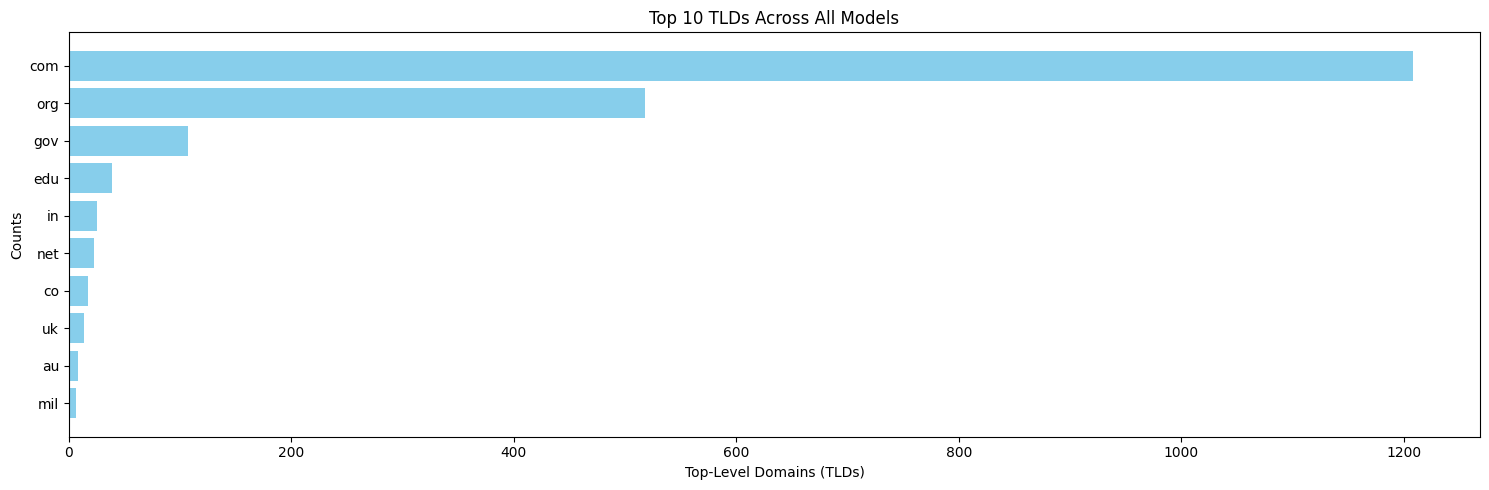

In [15]:
tld_counts = {}

for key, links in df_links_grouped.items():
    for link in links:
        if not link: 
            continue
        if not link.startswith(('https://')):
            link = 'https://' + link  
        domain = urlparse(link).netloc
        if not domain:
            continue
        tld = domain.split('.')[-1].strip()
        if tld in tld_counts:
            tld_counts[tld] += 1
        else:
            tld_counts[tld] = 1

top_10_tlds = sorted(tld_counts.items(), key=lambda item: item[1], reverse=True)[:10]
print(f'Top 10 TLDs Across All Models: \n\n{top_10_tlds}')
tlds, counts = zip(*top_10_tlds)

tlds = tlds[::-1]
counts = counts[::-1]

plt.figure(figsize=(15, 5))
plt.barh(tlds, counts, color='skyblue')
plt.xlabel('Top-Level Domains (TLDs)')
plt.ylabel('Counts')
plt.title('Top 10 TLDs Across All Models')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### <span style="color:blue">*Plot Insights:*</span> Our findings align very closely with the most popular TLDs worldwide[1].  We also felt that these TLDs and their corresponding counts made sense given the nature of the types of questions being asked (as well as their categories). 

[1]: **[Statista: Most popular top-level domains worldwide as of August 2024](https://www.statista.com/statistics/265677/number-of-internet-top-level-domains-worldwide/)** 


### <span style="color:black">Creating new feature columns for the primary TLDs</span>
#### In the next step, we continue with our `df_links_formatting_tld` deep copy DF and apply the counts of our highest TLDs (.com, .org, .gov, .edu and other).  As can be seen in the next cell, these top TLDs make up 92.54% of urls, which for simplicity and efficiency we deemed satisfactory for the purpose of this project and to minimize the complexity adding the other TLDs as feature columns in our DF. 

In [16]:
# To assess how many feature columns we need to create in our DF, we check to see the percentage of the top 4 TLDs in the dataset.

total_unique_tlds = sum(tld_counts.values())

tld_percentages = {tld: (count / total_unique_tlds) * 100 for tld, count in tld_counts.items() if tld in ['com', 'org', 'gov', 'edu']}

for tld, percentage in tld_percentages.items():
    print(f'{tld}: {percentage:.2f}%')

total = sum(tld_percentages.values())

print(f'\nTotal % of top TLDs out of all TLDs: {total:.2f}%')

org: 25.61%
com: 59.71%
gov: 5.29%
edu: 1.93%

Total % of top TLDs out of all TLDs: 92.54%


In [17]:
new_columns = ['.com count', '.org count', '.gov count', '.edu count', 'other count']
positions = [5, 6, 7, 8, 9]

for col, pos in zip(new_columns, positions):
    df_links_formatting_tld.insert(pos, col, 0)


def count_tlds(row):
    tld_counts = {
        '.com': 0,
        '.org': 0,
        '.gov': 0,
        '.edu': 0,
        'other': 0
    }
    links = row.split(', ')
    for link in links:
        link = link.strip()
        if not link.startswith(('http://', 'https://')):
            link = 'http://' + link
        tld_info = tldextract.extract(link)
        tld = '.' + tld_info.suffix
        if tld in tld_counts:
            tld_counts[tld] += 1
    return pd.Series(tld_counts)

df_links_formatting_tld['Attributed Sources'] = df_links_formatting_tld['Attributed Sources'].fillna('')
df_links_formatting_tld[['.com count', '.org count', '.gov count', '.edu count', 'other count']] = df_links_formatting_tld['Attributed Sources'].apply(count_tlds)

df_links_formatting_tld.head()

,Question,Question Category,LLM,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Are All Source Links Functional,Multi-modal Response
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,1,1,0,0,0,all_links_functional,text_only
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,3,0,0,0,0,all_links_functional,text_only
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,1,1,0,1,0,all_links_functional,text_only
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only


# <span style="color:black">Development of `'Trust Score'`:</span>

#### In our analysis of the dataset and project planning, we deemed it necessary to attempt to create a 'Trust Score' - a metric based on several characteristics of a model's output and source attribution.  

#### Our approach to scoring (`Trust Score`) consists of the following:

- Does the model provide sources explicitly?  + 5
- How robust are the attributed sources (# of sources provided)? + 1 for each unique link
- Are the model's provided sources easily accessible (do links work)?
    - All links work: + 2
    - Some links work: + 1
    - No links work: + 0
- Does the model provide increased learning opportunity (text only vs multi-modal)?
    - Multi-modal: + 2
    - Text Only: + 1

#### We decided not to include the counts of TLDs provided by the model.  This is due to the nature of source attribution being based on question/type of question being asked to the model and we determined it would not provide an accurate measurement of credibility.

In [18]:
df_trust_score = df.__deepcopy__()

df_trust_score.insert(7, 'Trust Score', 0)

for index, r in df_trust_score.iterrows():
    trust_score = 0 
    if r['Number of Sources'] > 0:
        trust_score += 5
    if r['Are All Source Links Functional'] == 'all_links_functional':
        trust_score += 2
    elif r['Are All Source Links Functional'] == 'some_links_funcitonal':
        trust_score += 1
    if r['Attributed Sources'] != '':
        unique_sources = set(r['Attributed Sources'].split(', '))
        trust_score += len(unique_sources)
    if r['Multi-modal Response'] == 'multi-modal':
        trust_score += 2
    elif r['Multi-modal Response'] == 'text_only':
        trust_score += 1

    df_trust_score.at[index, 'Trust Score'] = trust_score

df_trust_score.head()


,Question,Question Category,LLM,Attributed Sources,Number of Sources,Are All Source Links Functional,Multi-modal Response,Trust Score
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,all_links_functional,text_only,10
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,all_links_functional,text_only,9
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,all_links_functional,text_only,11
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,all_links_functional,text_only,11
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,all_links_functional,text_only,9


#### As we see below, there is significant differences in the trust score statistics across the models.  For example, 75% of Llama's and 50% of CoPilot's trust scores are below ChatGPT's minimum trust score and below ChatGPT's and Perplexity's 25th percentiles.  We see similar quartiles between ChatGPT and Perplexity, with the exception that ChatGPT's maximum score is considerably higher at 25 (vs Perplexity's 17).

In [19]:
mean_by_model = df_trust_score.groupby('LLM')['Trust Score'].mean()
print(f'Mean Trust Score by Model: \n\n{mean_by_model}\n\n')

quartiles_by_model = df_trust_score.groupby('LLM')['Trust Score'].describe(percentiles=[.25, .5, .75])
print(f'Quartiles of Trust Score by Model: \n\n{quartiles_by_model}')

Mean Trust Score by Model: 

LLM
chatGPT       16.46
copilot        5.66
gemini         9.96
llama          3.49
perplexity    15.28
Name: Trust Score, dtype: float64


Quartiles of Trust Score by Model: 

            count   mean       std   min   25%   50%    75%   max
LLM                                                              
chatGPT     100.0  16.46  2.401262  11.0  15.0  16.0  18.00  25.0
copilot     100.0   5.66  4.262166   1.0   1.0   9.0   9.00  11.0
gemini      100.0   9.96  4.565837   1.0   9.0  11.0  13.25  18.0
llama       100.0   3.49  3.831014   1.0   1.0   1.0   9.00  10.0
perplexity  100.0  15.28  2.225109   2.0  15.0  16.0  16.00  17.0


#### We wanted to investigate whether the category of question performed better or worse in trust scores to see if there were any underlying patterns in our dataset.

In [20]:
mean_trust_score_by_category = df_trust_score.groupby('Question Category')['Trust Score'].mean()
print(f'Mean Trust Score by Question Category: \n\n{mean_trust_score_by_category}\n\n')
print(f'Difference between lowest and highest mean trust scores: {mean_trust_score_by_category.max() - mean_trust_score_by_category.min()}')

Mean Trust Score by Question Category: 

Question Category
Economics & Commerce    10.742857
Entertainment            9.592000
Food & Cooking           9.933333
General Knowledge        9.866667
Geography               11.160000
History                 10.211111
Literature              10.800000
Philosophy              10.400000
Politics                 9.560000
Science & Technology     9.976471
Sports                  11.155556
Name: Trust Score, dtype: float64


Difference between lowest and highest mean trust scores: 1.5999999999999996


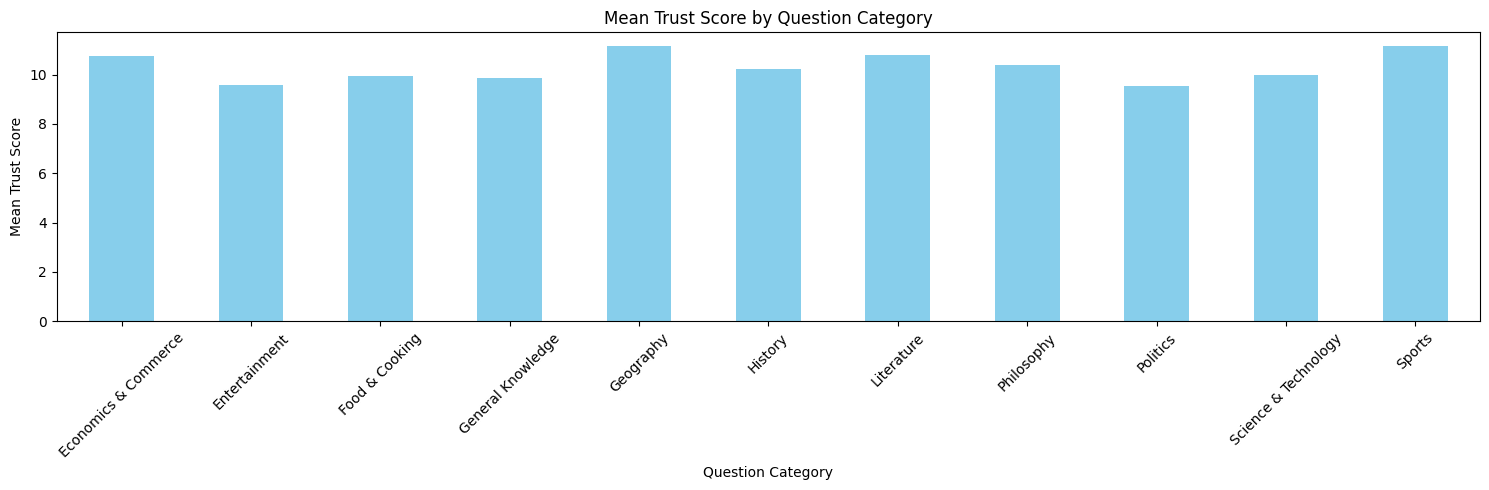

In [21]:
plt.figure(figsize=(15, 5))
df_trust_score.groupby('Question Category')['Trust Score'].mean().plot(kind='bar', color='skyblue')
plt.xlabel('Question Category')
plt.ylabel('Mean Trust Score')
plt.title('Mean Trust Score by Question Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### <span style="color:blue">*Plot Insights:*</span> Although we had unbalanced data across different categories, our analysis (shown above) demonstrates that across categories there is minimal differences in mean trust scores *holistically across all models*. The max difference in mean trust scores of only 1.69 points.


### Plotting Trust Score by Model & Question Category

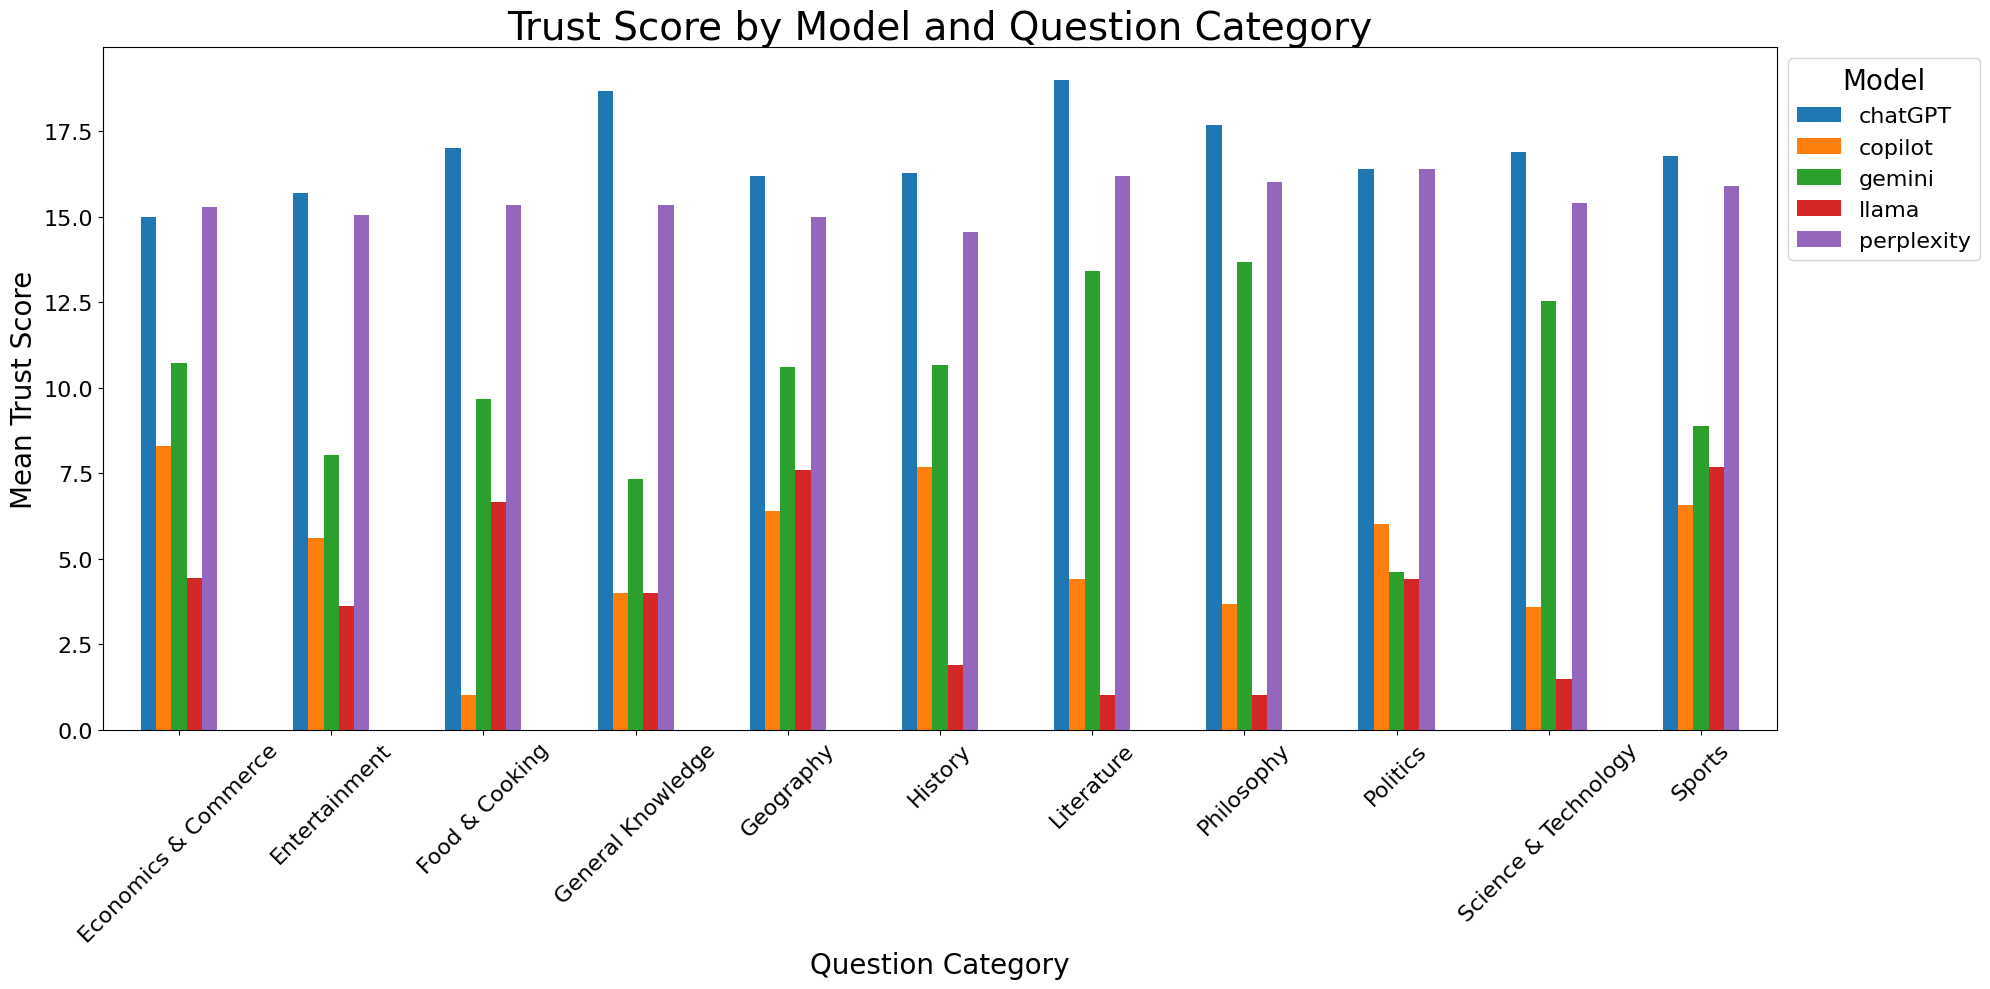

In [58]:
trust_score_by_model_by_category = df_trust_score.pivot_table(index='Question Category', columns='LLM', values='Trust Score', aggfunc='mean')
trust_score_by_model_by_category.plot(kind='bar', figsize=(20, 10))
plt.title('Trust Score by Model and Question Category', fontsize=28)
plt.xlabel('Question Category', fontsize=20)
plt.ylabel('Mean Trust Score', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
# plt.legend(title='Model', fontsize=16)
plt.legend(title='Model', fontsize=16, title_fontsize=20, 
          bbox_to_anchor=(1, 1), 
          loc='upper left')
plt.tight_layout()
plt.show()

#### <span style="color:blue">*Plot Insights:*</span> As seen in the previous plot, when plotted by question category and trust score (across all models), we saw little variation in trust scores by question category.  However, once we plot by model, we see some models had lower mean trust scores in some question categories compared to others.  For example, we see Meta's Llama had lower mean trust scores for the History, Literature, Philosophy, and Science & Technology categories.  One possible explanation of this is that Llama may not have given explicity sources for its responses in these categories and relied on its training data (which often resulted in no source being given).


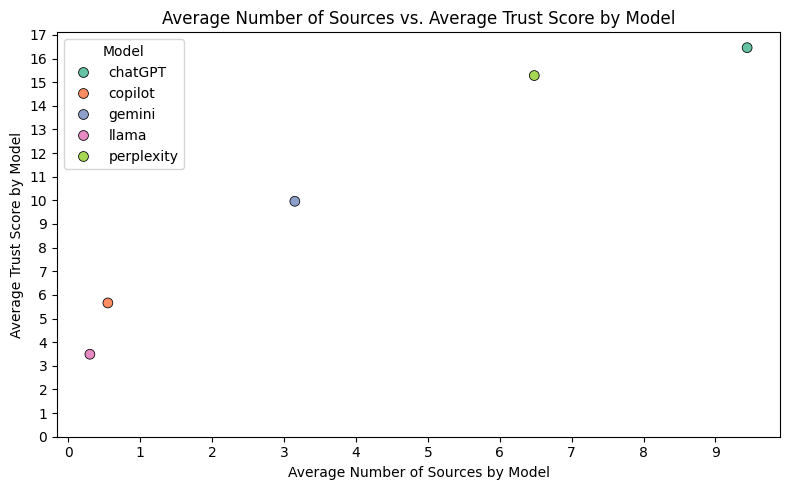

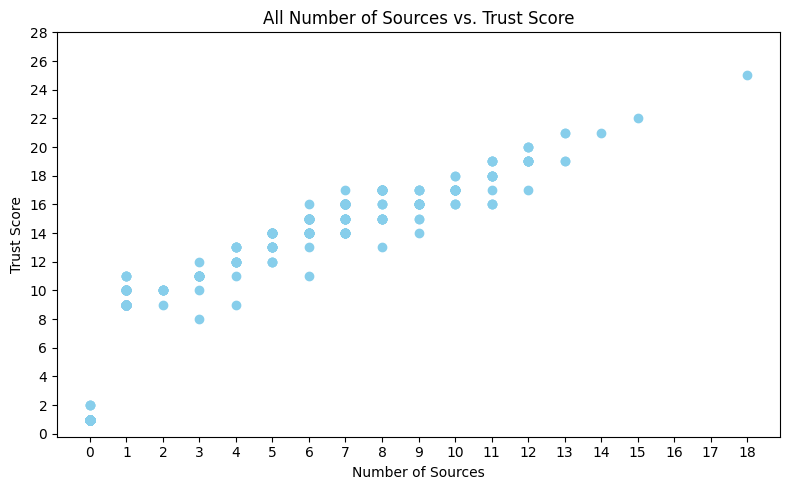

In [23]:
avg_trust_score_by_model = df_trust_score.groupby('LLM')['Trust Score'].mean()

plot_df = pd.DataFrame({
    'Average Number of Sources': avg_number_of_sources_by_model,
    'Average Trust Score': avg_trust_score_by_model
}).reset_index()

# Average Number of Sources vs. Average Trust Score by Model
plt.figure(figsize=(8, 5))
sns.scatterplot(data=plot_df, x='Average Number of Sources', y='Average Trust Score', hue='LLM', palette='Set2', s=50, edgecolor='black')
plt.xlabel('Average Number of Sources by Model')
plt.ylabel('Average Trust Score by Model')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 18, 1))
plt.title('Average Number of Sources vs. Average Trust Score by Model')
plt.legend(title='Model')
plt.tight_layout()

# All Number of Sources vs. Trust Score
plt.figure(figsize=(8, 5))
plt.scatter(df_trust_score['Number of Sources'], df_trust_score['Trust Score'], color='skyblue')
plt.xlabel('Number of Sources')
plt.xticks(np.arange(0, 19, 1))
plt.ylabel('Trust Score')
plt.yticks(np.arange(0, 30, 2))
plt.title('All Number of Sources vs. Trust Score')
plt.tight_layout()
plt.show()

#### <span style="color:blue">*Plot Insights:*</span> We can see an obvious positive linear relationship between the average number of sources provided and average trust score, as well as between the number of sources & the trust score.  We recognize that this is due to our defined trust scoring point system, however, it is also logical that when more sources are provided in context to answering a question, the receiver of that answer has greater ability to cross-reference/cross-validate sources to verify the accuracy of the information provided.


In [24]:
encoded_df = df_trust_score.copy()

encoder = LabelEncoder()
encoded_LLMs = encoder.fit_transform(encoded_df['LLM'])
encoded_df['LLM'] = encoded_LLMs + 1

encoded_question_categories = encoder.fit_transform(encoded_df['Question Category'])
encoded_df['Question Category'] = encoded_question_categories + 1

encoded_df = pd.get_dummies(encoded_df, columns=['Are All Source Links Functional', 'Multi-modal Response'], drop_first=True)

numeric_columns = encoded_df.select_dtypes(include=[np.number, 'bool']).columns
encoded_df[numeric_columns] = encoded_df[numeric_columns].astype(int)

encoded_df.head()

,Question,Question Category,LLM,Attributed Sources,Number of Sources,Trust Score,Are All Source Links Functional_no_links_functional,Are All Source Links Functional_some_links_functional,Multi-modal Response_text_only
0,"""where does the saying keeping up with the jon...",4,3,"www.commonlit.org, www.history.howstuffworks.com",2,10,0,0,1
1,"""when did day light savings start in the us""",6,3,www.wikipedia.org,1,9,0,0,1
2,"""what is the doll in the garden about""",2,3,"www.goodreads.com, amazon.com, www.publishersw...",3,11,0,0,1
3,"""where is a unitary system of government found""",9,3,"www.britannica.com, www.guides.skylinecollege....",3,11,0,0,1
4,"""who dies in season 2 of the originals""",2,3,www.wikipedia.org,1,9,0,0,1


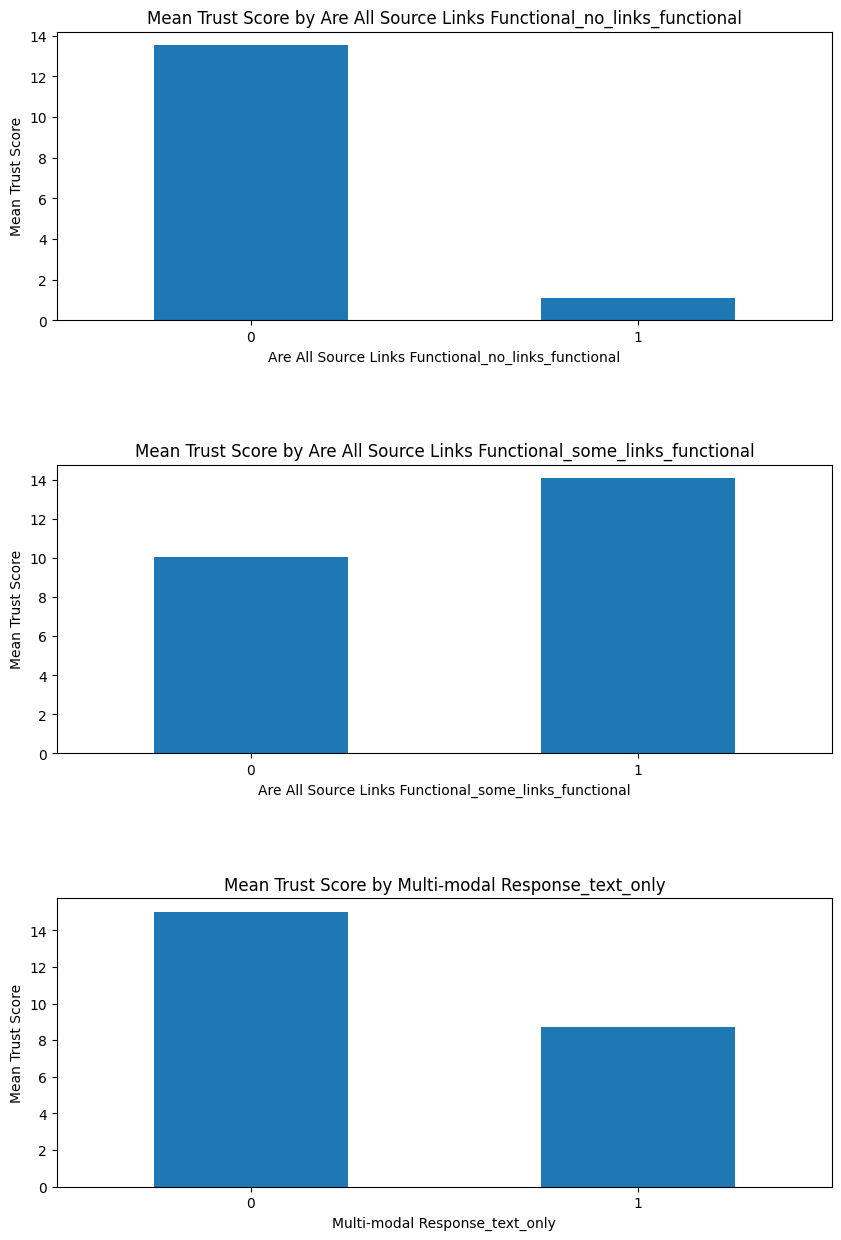

In [25]:
feature_columns2 = encoded_df.columns.difference(['Trust Score', 'LLM', 'Attributed Sources', 'Number of Sources', 'Question Category', 'Question', '.com count', '.org count', '.gov count', '.edu count', 'other count'])

fig, axes = plt.subplots(len(feature_columns2), 1, figsize=(10, len(feature_columns2) * 5))
axes = axes.flatten()

for ax, feature in zip(axes, feature_columns2):
    encoded_df.groupby(feature)['Trust Score'].mean().plot(kind='bar', ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Mean Trust Score')
    ax.set_title(f'Mean Trust Score by {feature}')
    ax.tick_params(axis='x', rotation=0)

plt.subplots_adjust(hspace=0.5)
plt.show()

#### <span style="color:blue">*Plot Insights:*</span> Similar to the plot insights of the plot comparing number of attributed sources/trust score, the above plots confirm what we suspected.  The models that provided either some functional links/all functional links and/or it provided multi-modal responses, the trust scores were higher.  When they provide no links and/or providing only text responses, the trust score was lower.


# <span style="color:black">Exploring the `'Question'` Feature:</span>

#### In this next section of EDA, we wanted to do some initial exploration around the Question feature column, specifically were there any significant observations related the interrogatory of the question and the corresponding number of sources provided and/or trust score.

In [26]:
df_questions_analysis = df_trust_score.__deepcopy__()
df_questions_analysis.head()

,Question,Question Category,LLM,Attributed Sources,Number of Sources,Are All Source Links Functional,Multi-modal Response,Trust Score
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,all_links_functional,text_only,10
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,all_links_functional,text_only,9
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,all_links_functional,text_only,11
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,all_links_functional,text_only,11
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,all_links_functional,text_only,9


In [27]:
def identify_interrogatory(question):
    interrogatories = ['where', 'why', 'what', 'who', 'how', 'when', 'which', 'describe', 'list', 'for which']
    question_lower = question.lower()
    for interrogatory in interrogatories:
        if f"{interrogatory} " in question_lower or question_lower.startswith(interrogatory):
            return interrogatory.lower()
    return None  

df_questions_analysis['Interrogatory'] = df_questions_analysis['Question'].apply(identify_interrogatory)

df_questions_analysis

,Question,Question Category,LLM,Attributed Sources,Number of Sources,Are All Source Links Functional,Multi-modal Response,Trust Score,Interrogatory
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,all_links_functional,text_only,10,where
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,all_links_functional,text_only,9,when
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,all_links_functional,text_only,11,what
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,all_links_functional,text_only,11,where
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,all_links_functional,text_only,9,who
...,...,...,...,...,...,...,...,...,...
595,"""who is the author of the book arabian nights?""",Literature,chatGPT,"www.newworldencyclopedia.org, www.britannica.c...",10.0,all_links_functional,text_only,17,who
596,"""who is the voice of tony the tiger?""",Economics & Commerce,chatGPT,"people.com, www.omahamagazine.com,www.wikipedi...",9.0,all_links_functional,text_only,16,who
597,"""who lives in the imperial palace in tokyo?""",History,chatGPT,"sankan.kunaicho.go.jp, www.japanmanifest.com, ...",11.0,all_links_functional,text_only,18,who
598,"""who played will on as the world turns?""",Entertainment,chatGPT,"www.wikipedia.org, www.looper.com, www.soapcen...",6.0,all_links_functional,text_only,14,who


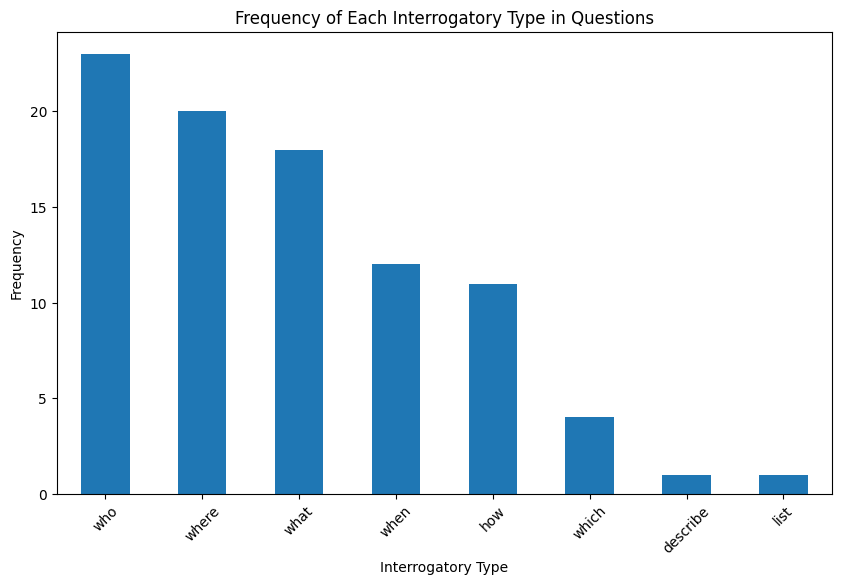

In [28]:
# Since our samples (questions) are the same for each model, we only need to analyze the first 100 rows of the dataset.

first_100_interrogatories = df_questions_analysis['Interrogatory'].iloc[:100]

plt.figure(figsize=(10, 6))
first_100_interrogatories.value_counts().plot(kind='bar')
plt.xlabel('Interrogatory Type')
plt.ylabel('Frequency')
plt.title('Frequency of Each Interrogatory Type in Questions')
plt.xticks(rotation=45)
plt.show()

#### <span style="color:blue">*Plot Insights:*</span> It is interesting to see the variation in number of interrogatories across our 100 sample questions.  Similar to the fact that we discovered that our question categories were imbalanced across the dataset, we see in ths above visual that our types of questions (interrogatories) are also imbalanced, with the majority of the questions being 'who', 'where', and 'what', and others such as 'which', 'describe', and 'list' make up a small minority of the question types.  There could be a variety of explanations for this, including that the original Natural Questions dataset was imbalanced - which may not be unrealistic if these types of questions are the most frequently types of questions asked by the population at large, which I think is a reasonable assumption.


In [29]:
mean_trust_score_by_interrogatory = df_questions_analysis.groupby('Interrogatory')['Trust Score'].mean()

print(mean_trust_score_by_interrogatory)

Interrogatory
describe    11.200000
how         10.127273
list        11.000000
what         9.700000
when         9.933333
where       10.410000
which       10.800000
who         10.530435
Name: Trust Score, dtype: float64


In [30]:
mean_sources_by_interrogatory = df_questions_analysis.groupby('Interrogatory')['Number of Sources'].mean()

print(mean_sources_by_interrogatory)

Interrogatory
describe    6.000000
how         3.727273
list        4.400000
what        4.011111
when        3.900000
where       4.150000
which       4.600000
who         3.817391
Name: Number of Sources, dtype: float64


In [31]:
def classify_objective_subjective(question):
    subjective_keywords = ['why', 'think', 'feel', 'should', 'opinion']
    question_lower = question.lower()
    for keyword in subjective_keywords:
        if keyword in question_lower:
            return 'Subjective'
    return 'Objective'

df_questions_analysis['Question Type'] = df_questions_analysis['Question'].apply(classify_objective_subjective)

df_questions_analysis.head()

,Question,Question Category,LLM,Attributed Sources,Number of Sources,Are All Source Links Functional,Multi-modal Response,Trust Score,Interrogatory,Question Type
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,"www.commonlit.org, www.history.howstuffworks.com",2.0,all_links_functional,text_only,10,where,Objective
1,"""when did day light savings start in the us""",History,gemini,www.wikipedia.org,1.0,all_links_functional,text_only,9,when,Objective
2,"""what is the doll in the garden about""",Entertainment,gemini,"www.goodreads.com, amazon.com, www.publishersw...",3.0,all_links_functional,text_only,11,what,Objective
3,"""where is a unitary system of government found""",Politics,gemini,"www.britannica.com, www.guides.skylinecollege....",3.0,all_links_functional,text_only,11,where,Objective
4,"""who dies in season 2 of the originals""",Entertainment,gemini,www.wikipedia.org,1.0,all_links_functional,text_only,9,who,Objective


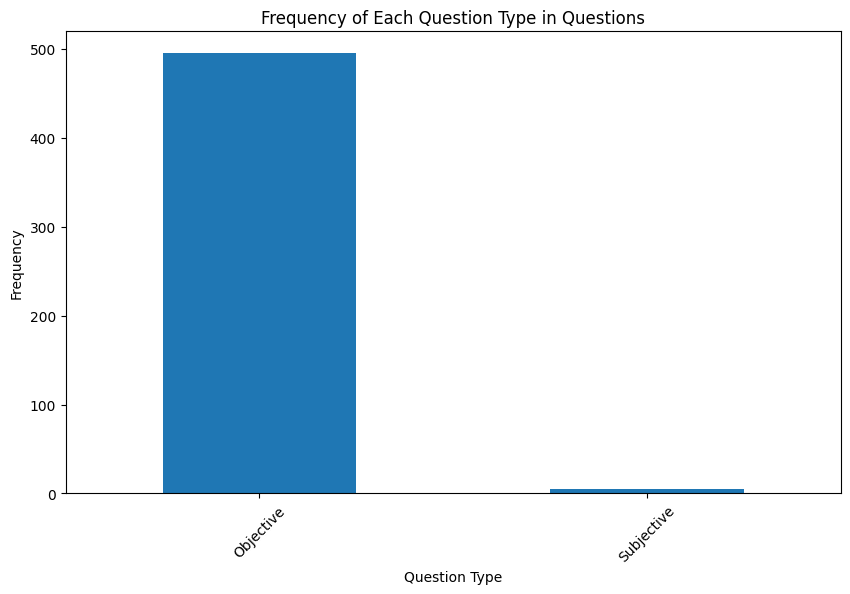

In [32]:
plt.figure(figsize=(10, 6))
df_questions_analysis['Question Type'].value_counts().plot(kind='bar')
plt.xlabel('Question Type')
plt.ylabel('Frequency')
plt.title('Frequency of Each Question Type in Questions')
plt.xticks(rotation=45)
plt.show()

#### <span style="color:blue">*Plot Insights:*</span> When we explored the type of question - objective vs subjective - it is very apparent that the overwhelming majority of our questions in our dataset are objective.  We recognize that subjective is being defined based on a small number of manually chosen keywords often associated with subjective questions, however, because this was a very introductory exploration into the question type, we felt this was a good starting point and there is potential for conducting more in-depth analysis in the future.


# <span style="color:black">Creation of Source Feature Columns From `'Attributed Sources'`:</span>

#### Next, we need to parse the individual urls provided (when source attribution was explicitly provided) by the model for each of the questions.  To do this, we separated all urls provided into their own feature column and provides encoded values representing the link's prescence in the record.  

#### We chose to use `Scikit-Learn's` `MultiLabelBinarizer` (MLB) method in this situation. Upon researching the differences between this and `OneHotEncoder` (OHE) method, MLB handles the possibility of multiple classes (urls) in a record whereas OHE handles binary classes.

#### Once we have created the new feature columns, the original `'Attributed Sources'` column is no longer needed for analysis purposes, so we remove it.

In [33]:
encoded_df['Attributed Sources'] = encoded_df['Attributed Sources'].apply(
    lambda x: [url.strip() for url in x.split(',')]
)

mlb = MultiLabelBinarizer()

url_features = pd.DataFrame(mlb.fit_transform(encoded_df['Attributed Sources']),
                            columns=mlb.classes_, index=encoded_df.index)

encoded_df = pd.concat([encoded_df, url_features], axis=1)

encoded_df.drop(columns=['Attributed Sources'], inplace=True)

display(encoded_df.head())


,Question,Question Category,LLM,Number of Sources,Trust Score,Are All Source Links Functional_no_links_functional,Are All Source Links Functional_some_links_functional,Multi-modal Response_text_only,,2001-2009.state.gov,...,www.yellowbrick.co,www.yourdictionary.com,www.youtube.com,www.zavvi.com,www.zerohanger.com,wwww.britannica.com,y20india.in,yaleclimateconnections.org,yourstory.com,youtube.com
0,"""where does the saying keeping up with the jon...",4,3,2,10,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"""when did day light savings start in the us""",6,3,1,9,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"""what is the doll in the garden about""",2,3,3,11,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"""where is a unitary system of government found""",9,3,3,11,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"""who dies in season 2 of the originals""",2,3,1,9,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# <span style="color:black">Considerations for Future Analysis:</span>

- #### **User Feedback & Ratings on Question/Answer Quality:**  We feel that user provided satisfaction ratings of the model responses would enable us to get a more relevant and accurate `Trust Score` rating.  

- #### **Balance Question Category Representation in the Dataset:**  During our EDA, we discovered that some question categories were more present in our dataset than others.  As mentioned above, we selected our training questions randomly from `Google's Natural Questions` dataset, however, based on our dataset we felt that further efforts are needed to supplement our dataset with more data from the under-represented categories in the future.

- #### **Retain All Attributed Source Urls (Do Not Remove Duplicate Domains):**  In our initial project planning, we decided to remove duplicate domains provided in a model's response (i.e. if a model provided two different pages from the same domain, such as www.wikipedia.org, we only counted the domain once).  We made this decision because we felt that in the context of a model's decision of where to get it's information from, the credibility of that source remains the same.  Although we believe this is an acceptable approach towards analyzing this question of model transparency/credibility, we also recognize the benefit of retaining all urls, even duplicate domains.  Three possible benefits we see of not removing duplicate domains:
    - #### It could potentially reveal additional patterns in the the data we were not aware of
    - #### Retaining all domains could also result in a higher weight for a source (meaning its possible that specific source is more credible).  
    - #### It is possible that the use of a domain repeatedly could reveal insights into the type of question asked,